In [1]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

from custom_models import get_cell_based_tiny_net
from custom_search_cells import NAS201SearchCell as SearchCell
from xautodl.models.cell_searchs.genotypes import Structure

# NB201
from nas_201_api import NASBench201API as API

import scipy.stats as stats

2022-11-01 04:05:19.115283: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
parser = argparse.ArgumentParser("Random search for NAS.")
parser.add_argument("--data_path", type=str, default='../cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space_name", type=str, default='nas-bench-201', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./MY.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")
# log
parser.add_argument("--workers", type=int, default=4, help="number of data loading workers")
parser.add_argument("--save_dir", type=str, default='./include_none_increase_lr-loop2-2_ep2', help="Folder to save checkpoints and log.")
# parser.add_argument("--arch_nas_dataset", type=str, default='../NAS-Bench-201-v1_1-096897.pth', help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--arch_nas_dataset", type=str, default=None, help="The path to load the architecture dataset (tiny-nas-benchmark).")
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])
if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

    
print(args.rand_seed)
print(args)
xargs=args

1473
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=1473, save_dir='./include_none_increase_lr-loop2-2_ep2', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=include_none_increase_lr-loop2-2_ep2, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 1473
save_dir         : ./include_none_increase_lr-loop2-2_ep2
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.test_batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": bool(xargs.track_running_stats),
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))
# if xargs.arch_nas_dataset is None:
api = None
# else:
#     api = API(xargs.arch_nas_dataset)
logger.log("{:} create API = {:} done".format(time_string(), api))

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)
network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

if last_info.exists():  # automatically resume from previous checkpoint
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start".format(last_info)
    )
    last_info = torch.load(last_info)
    start_epoch = last_info["epoch"]
    checkpoint = torch.load(last_info["last_checkpoint"])
    genotypes = checkpoint["genotypes"]
    valid_accuracies = checkpoint["valid_accuracies"]
    search_model.load_state_dict(checkpoint["search_model"])
    w_scheduler.load_state_dict(checkpoint["w_scheduler"])
    w_optimizer.load_state_dict(checkpoint["w_optimizer"])
    logger.log(
        "=> loading checkpoint of the last-info '{:}' start with {:}-th epoch.".format(
            last_info, start_epoch
        )
    )
else:
    logger.log("=> do not find the last-info file : {:}".format(last_info))
    start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=200, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=200, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
w-optimizer : SGD (
Parameter Group 0
    dampening: 0
    foreach: None
    initial_lr: 0.025
    lr: 0.025
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 0.0005
)
w-scheduler : CosineAnnealingLR(warmup=0, max-epoch=200, current::epoch=0, iter=0.00, type=cosine, T-max=200, eta-min=0.001)
criterion   : CrossEntropyL

In [5]:
def acc_confidence_robustness_metrics(network, inputs, targets):
    with torch.no_grad():
        # accuracy
        network.train()
        _, logits = network(inputs)
        val_top1, val_top5 = obtain_accuracy(logits.data, targets.data, topk=(1, 5))
        acc = val_top1
        
        # confidence
        prob = torch.nn.functional.softmax(logits, dim=1)
        one_hot_idx = torch.nn.functional.one_hot(targets)
        confidence = (prob[one_hot_idx==1].sum()) / inputs.size(0) * 100 # in percent
        
        # sensitivity
        _, noisy_logits = network(inputs + torch.randn_like(inputs)*0.1)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        sensitivity = kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        
        # robustness
        original_weights = deepcopy(network.state_dict())
        for m in network.modules():
            if isinstance(m, SearchCell):
                for p in m.parameters():
                    p.add_(torch.randn_like(p) * p.std()*0.3)
            
        _, noisy_logits = network(inputs)
        kl_loss = torch.nn.KLDivLoss(reduction="batchmean")
        robustness = -kl_loss(torch.nn.functional.log_softmax(noisy_logits, dim=1), torch.nn.functional.softmax(logits, dim=1))
        network.load_state_dict(original_weights)
                
        return acc.item(), confidence.item(), sensitivity.item(), robustness.item()
    
def step_sim_metric(network, criterion, inputs, targets):
    original_dict = deepcopy(network.state_dict())
    optim_large_step = torch.optim.SGD(network.parameters(), lr=0.025)
    
    # single large step
    network.train()
    optim_large_step.zero_grad()
    _, logits = network(inputs)
    base_loss = criterion(logits, targets)
    base_loss.backward()
    optim_large_step.step()
    large_step_dict = deepcopy(network.state_dict())
    
    # multiple small steps
    network.load_state_dict(original_dict)
    optim_small_step = torch.optim.SGD(network.parameters(), lr=0.025/3)
    for i in range(3):
        optim_small_step.zero_grad()
        _, logits = network(inputs)
        base_loss = criterion(logits, targets)
        base_loss.backward()
        optim_small_step.step()
    small_step_dict = deepcopy(network.state_dict())
    scores = []
    for key in large_step_dict.keys():
        if ('weight' in key) and (original_dict[key].dim()==4):
            if (original_dict[key] != large_step_dict[key]).sum():
                large_step = large_step_dict[key] - original_dict[key]
                small_step = small_step_dict[key] - original_dict[key]
                co, ci, kh, kw = large_step.size()
                large_step = large_step.view(co, -1)
                small_step = small_step.view(co, -1)
                score = torch.nn.functional.cosine_similarity(large_step, small_step, dim=1)
                score = score.mean().item() * 100 # in percent
                scores.append(score)
    if len(scores)==0:
        step_sim = 100
        raise RuntimeError
    else:
        step_sim = np.mean(scores)
    
    # resume
    network.load_state_dict(original_dict)
            
    return step_sim

In [ ]:
# start training
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)

################# initialize
cells = []
for m in network.modules():
    if isinstance(m, SearchCell):
        cells.append(m)
num_cells = len(cells)
print("total number of nodes:{}".format(num_cells*xargs.max_nodes))
        
op_names = deepcopy(cells[0].op_names)
op_names_wo_none = deepcopy(op_names)
if "none" in op_names_wo_none:
    op_names_wo_none.remove("none")

genotypes = []
for i in range(1, xargs.max_nodes):
    xlist = []
    for j in range(i):
        node_str = "{:}<-{:}".format(i, j)
        if i-j==1:
            op_name = "skip_connect"
        else:
            op_name = "none"
        xlist.append((op_name, j))
    genotypes.append(tuple(xlist))
init_arch = Structure(genotypes)

for c in cells:
    c.arch_cache = init_arch

### gen possible connections of a target node
possible_connections = {}
for target_node_idx in range(1,xargs.max_nodes):
    possible_connections[target_node_idx] = list()
    xlists = []
    for src_node in range(target_node_idx):
        node_str = "{:}<-{:}".format(target_node_idx, src_node)
        # select possible ops
#         if target_node_idx - src_node == 1:
#             op_names_tmp = op_names_wo_none
#         else:
#             op_names_tmp = op_names
        op_names_tmp = op_names
            
        if len(xlists) == 0: # initial iteration
            for op_name in op_names_tmp:
                xlists.append([(op_name, src_node)])
        else:
            new_xlists = []
            for op_name in op_names_tmp:
                for xlist in xlists:
                    new_xlist = deepcopy(xlist)
                    new_xlist.append((op_name, src_node))
                    new_xlists.append(new_xlist)
            xlists = new_xlists
    for xlist in xlists:
        selected_ops = []
        for l in xlist:
            selected_ops.append(l[0])
        if sum(np.array(selected_ops) == "none") == len(selected_ops):
            continue
        possible_connections[target_node_idx].append(tuple(xlist))
    print("target_node:{}".format(target_node_idx), len(possible_connections[target_node_idx]))
        
### train while generating random architectures by mutating connections of a target node

for arch_loop in range(2):
    for target_cell_idx in range(num_cells):
        for cell_loop in range(2):
            target_cell = cells[target_cell_idx]
            print("\n\n Searching with a cell #{}".format(target_cell_idx))
            for target_node_idx in range(1,xargs.max_nodes):
                current_genotypes,_ = target_cell.arch_cache.tolist(None)
                print("\nCurrent target cell:{} / current target node:{}".format(target_cell_idx, target_node_idx))
                ## training
                for ep in range(2):
                    data_time, batch_time = AverageMeter(), AverageMeter()
                    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
                    network.train()
                    end = time.time()
                    print_freq = 200
                    for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(search_loader):
                        ######### random generation
                        genotypes = deepcopy(current_genotypes)
                        connection = random.choice(possible_connections[target_node_idx])
                        genotypes[target_node_idx-1] = connection
                        arch = Structure(genotypes)
                        target_cell.arch_cache = arch

                        ######### forward/backward/optim
                        base_targets = base_targets.cuda(non_blocking=True)
                        arch_targets = arch_targets.cuda(non_blocking=True)
                        # measure data loading time
                        data_time.update(time.time() - end)
                        w_optimizer.zero_grad()
                        _, logits = network(base_inputs)
                        base_loss = criterion(logits, base_targets)
                        base_loss.backward()
                        nn.utils.clip_grad_norm_(network.parameters(), 5)
                        w_optimizer.step()

                        ######### logging
                        base_prec1, base_prec5 = obtain_accuracy(logits.data, base_targets.data, topk=(1, 5))
                        base_losses.update(base_loss.item(), base_inputs.size(0))
                        base_top1.update(base_prec1.item(), base_inputs.size(0))
                        base_top5.update(base_prec5.item(), base_inputs.size(0))
                        batch_time.update(time.time() - end)
                        end = time.time()
                        if step % print_freq == 0 or step + 1 == len(search_loader):
                            Sstr = ("*Train* "+ time_string()+" Ep:{:} [{:03d}/{:03d}]".format(ep, step, len(search_loader)))
                            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(batch_time=batch_time, data_time=data_time)
                            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(loss=base_losses, top1=base_top1, top5=base_top5)
                            logger.log(Sstr + " " + Tstr + " " + Wstr)

                    logger.log("Ep:{:} ends : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(ep, base_losses.avg, base_top1.avg, base_top5.avg))
                ## evaluation
                network.train()
                archs, metric_accs, metric_confidences, metric_sensitivities, metric_robustnesses, metric_step_sims = [], [], [], [], [], []
                loader_iter = iter(valid_loader)
                for connection in possible_connections[target_node_idx]:
                    ###### traverse over possible archs
                    genotypes = deepcopy(current_genotypes)
                    genotypes[target_node_idx-1] = connection
                    arch = Structure(genotypes)
                    target_cell.arch_cache = arch
                    ###### measure metrics
                    try:
                        inputs, targets = next(loader_iter)
                    except:
                        loader_iter = iter(valid_loader)
                        inputs, targets = next(loader_iter)
                    inputs, targets = inputs.cuda(non_blocking=True), targets.cuda(non_blocking=True)
                    valid_acc, confidence, sensitivity, robustness = acc_confidence_robustness_metrics(network, inputs, targets)
                    step_sim = step_sim_metric(network, criterion, inputs, targets)
                    archs.append(arch)
                    metric_accs.append(valid_acc)
                    metric_confidences.append(confidence)
                    metric_sensitivities.append(sensitivity)
                    metric_robustnesses.append(robustness)
                    metric_step_sims.append(step_sim)
                rank_accs, rank_confidences, rank_sensitivities, rank_robustnesses, rank_step_sims = stats.rankdata(metric_accs), stats.rankdata(metric_confidences), stats.rankdata(metric_sensitivities), stats.rankdata(metric_robustnesses), stats.rankdata(metric_step_sims)
                l = len(rank_accs)
                rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_robustnesses/l)+np.log(rank_step_sims/l)
    #             rank_agg = np.log(rank_accs/l)+np.log(rank_confidences/l)+np.log(rank_sensitivities/l)+np.log(rank_step_sims/l)
                best_idx = np.argmax(rank_agg)
                best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim = archs[best_idx], metric_accs[best_idx], metric_confidences[best_idx], metric_sensitivities[best_idx], metric_robustnesses[best_idx], metric_step_sims[best_idx]
                logger.log("Found best op for target cell:{} / target node:{}".format(target_cell_idx, target_node_idx))
                logger.log(": {:} with accuracy={:.2f}%, confidence={:.3f}%, sensitivity={:.3f}, robustness={:.3f}, step_sim={:.3f}".format(best_arch, best_acc, best_conf, best_sensitivity, best_robust, best_step_sim))
                target_cell.arch_cache = best_arch
            
best_archs = []
for c in cells:
    best_archs.append(c.arch_cache)
    
torch.save({"model":search_model.state_dict(), "best_archs":best_archs}, os.path.join(xargs.save_dir, "output.pth"))

for m in search_model.modules():
    if isinstance(m, SearchCell):
        logger.log(m.arch_cache)

logger.close()

total number of nodes:60
target_node:1 4
target_node:2 24
target_node:3 124


 Searching with a cell #0

Current target cell:0 / current target node:1
*Train* [2022-11-01 04:05:24] Ep:0 [000/391] Time 2.78 (2.78) Data 0.17 (0.17) Base [Loss 2.334 (2.334)  Prec@1 15.62 (15.62) Prec@5 45.31 (45.31)]
*Train* [2022-11-01 04:05:40] Ep:0 [200/391] Time 0.12 (0.09) Data 0.00 (0.00) Base [Loss 1.674 (1.952)  Prec@1 35.94 (26.00) Prec@5 90.62 (79.66)]
*Train* [2022-11-01 04:06:01] Ep:0 [390/391] Time 0.11 (0.10) Data 0.00 (0.00) Base [Loss 1.648 (1.832)  Prec@1 40.00 (30.77) Prec@5 85.00 (83.65)]
Ep:0 ends : loss=1.83, accuracy@1=30.77%, accuracy@5=83.65%
*Train* [2022-11-01 04:06:01] Ep:1 [000/391] Time 0.32 (0.32) Data 0.25 (0.25) Base [Loss 1.846 (1.846)  Prec@1 39.06 (39.06) Prec@5 82.81 (82.81)]
*Train* [2022-11-01 04:06:17] Ep:1 [200/391] Time 0.11 (0.08) Data 0.00 (0.00) Base [Loss 1.492 (1.599)  Prec@1 43.75 (40.73) Prec@5 90.62 (89.94)]
*Train* [2022-11-01 04:06:32] Ep:1 [390/391] Time

*Train* [2022-11-01 04:17:34] Ep:0 [200/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 1.075 (1.014)  Prec@1 60.94 (64.74) Prec@5 98.44 (96.43)]
*Train* [2022-11-01 04:17:51] Ep:0 [390/391] Time 0.12 (0.10) Data 0.00 (0.00) Base [Loss 0.792 (0.971)  Prec@1 67.50 (65.86) Prec@5 100.00 (96.89)]
Ep:0 ends : loss=0.97, accuracy@1=65.86%, accuracy@5=96.89%
*Train* [2022-11-01 04:17:51] Ep:1 [000/391] Time 0.38 (0.38) Data 0.24 (0.24) Base [Loss 1.083 (1.083)  Prec@1 60.94 (60.94) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 04:18:09] Ep:1 [200/391] Time 0.06 (0.09) Data 0.00 (0.00) Base [Loss 0.926 (0.915)  Prec@1 64.06 (67.70) Prec@5 100.00 (97.29)]
*Train* [2022-11-01 04:18:23] Ep:1 [390/391] Time 0.06 (0.08) Data 0.00 (0.00) Base [Loss 1.085 (0.886)  Prec@1 57.50 (68.80) Prec@5 97.50 (97.58)]
Ep:1 ends : loss=0.89, accuracy@1=68.80%, accuracy@5=97.58%
Found best op for target cell:1 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_conn

*Train* [2022-11-01 04:30:02] Ep:1 [000/391] Time 0.37 (0.37) Data 0.24 (0.24) Base [Loss 0.696 (0.696)  Prec@1 73.44 (73.44) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 04:30:28] Ep:1 [200/391] Time 0.20 (0.13) Data 0.00 (0.00) Base [Loss 1.029 (0.727)  Prec@1 64.06 (74.82) Prec@5 98.44 (98.38)]
*Train* [2022-11-01 04:30:51] Ep:1 [390/391] Time 0.06 (0.13) Data 0.00 (0.00) Base [Loss 0.721 (0.728)  Prec@1 77.50 (74.74) Prec@5 100.00 (98.32)]
Ep:1 ends : loss=0.73, accuracy@1=74.74%, accuracy@5=98.32%
Found best op for target cell:2 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=74.80%, confidence=62.561%, sensitivity=0.067, robustness=-0.011, step_sim=99.734

Current target cell:2 / current target node:2
*Train* [2022-11-01 04:30:56] Ep:0 [000/391] Time 0.35 (0.35) Data 0.27 (0.27) Base [Loss 2.203 (2.203)  Prec@1 28.12 (28.12) Prec@5 75.00 (75.00)]
*Train* [2022-11-01 04:31:11] Ep:0 [200/391] Time 0.13 (

*Train* [2022-11-01 04:42:03] Ep:1 [390/391] Time 0.13 (0.11) Data 0.00 (0.00) Base [Loss 0.624 (0.683)  Prec@1 80.00 (76.10) Prec@5 97.50 (98.57)]
Ep:1 ends : loss=0.68, accuracy@1=76.10%, accuracy@5=98.57%
Found best op for target cell:3 / target node:1
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=72.85%, confidence=61.424%, sensitivity=0.081, robustness=-0.014, step_sim=99.414

Current target cell:3 / current target node:2
*Train* [2022-11-01 04:42:06] Ep:0 [000/391] Time 0.38 (0.38) Data 0.23 (0.23) Base [Loss 3.777 (3.777)  Prec@1 7.81 (7.81) Prec@5 56.25 (56.25)]
*Train* [2022-11-01 04:42:24] Ep:0 [200/391] Time 0.08 (0.09) Data 0.00 (0.00) Base [Loss 0.819 (0.744)  Prec@1 78.12 (74.78) Prec@5 96.88 (98.07)]
*Train* [2022-11-01 04:42:40] Ep:0 [390/391] Time 0.06 (0.09) Data 0.00 (0.00) Base [Loss 0.668 (0.714)  Prec@1 77.50 (75.66) Prec@5 97.50 (98.29)]
Ep:0 ends : loss=0.71, accuracy@1=75.66%, accuracy@5=98.29%
*

*Train* [2022-11-01 04:54:19] Ep:0 [000/391] Time 0.38 (0.38) Data 0.23 (0.23) Base [Loss 0.539 (0.539)  Prec@1 81.25 (81.25) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 04:54:47] Ep:0 [200/391] Time 0.13 (0.14) Data 0.00 (0.00) Base [Loss 0.631 (0.734)  Prec@1 79.69 (75.00) Prec@5 96.88 (98.06)]
*Train* [2022-11-01 04:55:07] Ep:0 [390/391] Time 0.14 (0.12) Data 0.00 (0.00) Base [Loss 0.523 (0.700)  Prec@1 82.50 (76.25) Prec@5 100.00 (98.40)]
Ep:0 ends : loss=0.70, accuracy@1=76.25%, accuracy@5=98.40%
*Train* [2022-11-01 04:55:08] Ep:1 [000/391] Time 0.33 (0.33) Data 0.23 (0.23) Base [Loss 0.676 (0.676)  Prec@1 75.00 (75.00) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 04:55:23] Ep:1 [200/391] Time 0.07 (0.08) Data 0.00 (0.00) Base [Loss 0.455 (0.637)  Prec@1 84.38 (77.67) Prec@5 98.44 (98.85)]
*Train* [2022-11-01 04:55:38] Ep:1 [390/391] Time 0.12 (0.08) Data 0.00 (0.00) Base [Loss 0.594 (0.649)  Prec@1 80.00 (77.41) Prec@5 97.50 (98.78)]
Ep:1 ends : loss=0.65, accuracy@1=77.41%, accurac

*Train* [2022-11-01 05:07:31] Ep:0 [390/391] Time 0.13 (0.09) Data 0.00 (0.00) Base [Loss 0.592 (0.728)  Prec@1 77.50 (75.25) Prec@5 100.00 (98.10)]
Ep:0 ends : loss=0.73, accuracy@1=75.25%, accuracy@5=98.10%
*Train* [2022-11-01 05:07:31] Ep:1 [000/391] Time 0.32 (0.32) Data 0.23 (0.23) Base [Loss 0.694 (0.694)  Prec@1 76.56 (76.56) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 05:07:59] Ep:1 [200/391] Time 0.13 (0.14) Data 0.00 (0.00) Base [Loss 0.665 (0.607)  Prec@1 79.69 (79.27) Prec@5 98.44 (98.90)]
*Train* [2022-11-01 05:08:21] Ep:1 [390/391] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.680 (0.626)  Prec@1 80.00 (78.54) Prec@5 100.00 (98.79)]
Ep:1 ends : loss=0.63, accuracy@1=78.54%, accuracy@5=98.79%
Found best op for target cell:5 / target node:2
: Structure(4 nodes with |skip_connect~0|+|none~0|skip_connect~1|+|none~0|none~1|skip_connect~2|) with accuracy=75.20%, confidence=65.063%, sensitivity=0.097, robustness=-0.031, step_sim=99.648

Current target cell:5 / current target no

*Train* [2022-11-01 05:20:08] Ep:1 [200/391] Time 0.12 (0.12) Data 0.00 (0.00) Base [Loss 0.487 (0.609)  Prec@1 82.81 (78.98) Prec@5 100.00 (98.79)]
*Train* [2022-11-01 05:20:33] Ep:1 [390/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.490 (0.604)  Prec@1 85.00 (79.10) Prec@5 97.50 (98.88)]
Ep:1 ends : loss=0.60, accuracy@1=79.10%, accuracy@5=98.88%
Found best op for target cell:6 / target node:2
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|nor_conv_1x1~1|+|none~0|none~1|skip_connect~2|) with accuracy=75.39%, confidence=65.038%, sensitivity=0.128, robustness=-0.034, step_sim=99.606

Current target cell:6 / current target node:3
*Train* [2022-11-01 05:20:51] Ep:0 [000/391] Time 0.37 (0.37) Data 0.23 (0.23) Base [Loss 0.788 (0.788)  Prec@1 70.31 (70.31) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 05:21:13] Ep:0 [200/391] Time 0.07 (0.11) Data 0.00 (0.00) Base [Loss 0.676 (0.723)  Prec@1 78.12 (75.18) Prec@5 98.44 (98.18)]
*Train* [2022-11-01 05:21:29] Ep:0 [390/391] Tim

Found best op for target cell:7 / target node:2
: Structure(4 nodes with |avg_pool_3x3~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|none~0|none~1|skip_connect~2|) with accuracy=77.34%, confidence=67.234%, sensitivity=0.115, robustness=-0.046, step_sim=99.617

Current target cell:7 / current target node:3
*Train* [2022-11-01 05:34:23] Ep:0 [000/391] Time 0.48 (0.48) Data 0.23 (0.23) Base [Loss 2.889 (2.889)  Prec@1 14.06 (14.06) Prec@5 60.94 (60.94)]
*Train* [2022-11-01 05:34:49] Ep:0 [200/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.678 (0.707)  Prec@1 78.12 (75.26) Prec@5 96.88 (97.84)]
*Train* [2022-11-01 05:35:13] Ep:0 [390/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.516 (0.656)  Prec@1 82.50 (77.20) Prec@5 100.00 (98.37)]
Ep:0 ends : loss=0.66, accuracy@1=77.20%, accuracy@5=98.37%
*Train* [2022-11-01 05:35:14] Ep:1 [000/391] Time 0.45 (0.45) Data 0.28 (0.28) Base [Loss 0.377 (0.377)  Prec@1 85.94 (85.94) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 05:35:31] Ep:1 [200/391] Tim

*Train* [2022-11-01 05:47:51] Ep:0 [000/391] Time 0.33 (0.33) Data 0.25 (0.25) Base [Loss 0.581 (0.581)  Prec@1 78.12 (78.12) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 05:48:16] Ep:0 [200/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.681 (0.676)  Prec@1 79.69 (77.06) Prec@5 98.44 (98.04)]
*Train* [2022-11-01 05:48:39] Ep:0 [390/391] Time 0.07 (0.13) Data 0.00 (0.00) Base [Loss 0.693 (0.635)  Prec@1 80.00 (78.40) Prec@5 97.50 (98.40)]
Ep:0 ends : loss=0.64, accuracy@1=78.40%, accuracy@5=98.40%
*Train* [2022-11-01 05:48:40] Ep:1 [000/391] Time 0.39 (0.39) Data 0.25 (0.25) Base [Loss 0.501 (0.501)  Prec@1 82.81 (82.81) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 05:49:07] Ep:1 [200/391] Time 0.12 (0.14) Data 0.00 (0.00) Base [Loss 0.541 (0.567)  Prec@1 84.38 (80.48) Prec@5 98.44 (99.07)]
*Train* [2022-11-01 05:49:32] Ep:1 [390/391] Time 0.13 (0.13) Data 0.00 (0.00) Base [Loss 0.692 (0.569)  Prec@1 85.00 (80.42) Prec@5 95.00 (99.03)]
Ep:1 ends : loss=0.57, accuracy@1=80.42%, accuracy@5

*Train* [2022-11-01 06:02:07] Ep:0 [390/391] Time 0.07 (0.10) Data 0.00 (0.00) Base [Loss 0.580 (0.602)  Prec@1 77.50 (79.60) Prec@5 97.50 (98.85)]
Ep:0 ends : loss=0.60, accuracy@1=79.60%, accuracy@5=98.85%
*Train* [2022-11-01 06:02:07] Ep:1 [000/391] Time 0.33 (0.33) Data 0.25 (0.25) Base [Loss 0.417 (0.417)  Prec@1 89.06 (89.06) Prec@5 96.88 (96.88)]
*Train* [2022-11-01 06:02:33] Ep:1 [200/391] Time 0.07 (0.13) Data 0.00 (0.00) Base [Loss 0.579 (0.544)  Prec@1 75.00 (81.41) Prec@5 98.44 (99.04)]
*Train* [2022-11-01 06:02:54] Ep:1 [390/391] Time 0.21 (0.12) Data 0.00 (0.00) Base [Loss 0.493 (0.549)  Prec@1 80.00 (81.12) Prec@5 100.00 (99.07)]
Ep:1 ends : loss=0.55, accuracy@1=81.12%, accuracy@5=99.07%
Found best op for target cell:9 / target node:3
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|nor_conv_3x3~1|+|nor_conv_1x1~0|avg_pool_3x3~1|none~2|) with accuracy=76.56%, confidence=68.467%, sensitivity=0.131, robustness=-0.053, step_sim=99.609


 Searching with a cell #9



*Train* [2022-11-01 06:16:18] Ep:1 [200/391] Time 0.07 (0.11) Data 0.00 (0.00) Base [Loss 0.321 (0.497)  Prec@1 87.50 (83.01) Prec@5 100.00 (99.19)]
*Train* [2022-11-01 06:16:35] Ep:1 [390/391] Time 0.08 (0.10) Data 0.00 (0.00) Base [Loss 0.560 (0.504)  Prec@1 85.00 (82.78) Prec@5 100.00 (99.13)]
Ep:1 ends : loss=0.50, accuracy@1=82.78%, accuracy@5=99.13%
Found best op for target cell:10 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|avg_pool_3x3~1|+|avg_pool_3x3~0|none~1|nor_conv_3x3~2|) with accuracy=79.30%, confidence=72.014%, sensitivity=0.135, robustness=-0.060, step_sim=99.657


 Searching with a cell #10

Current target cell:10 / current target node:1
*Train* [2022-11-01 06:18:33] Ep:0 [000/391] Time 0.35 (0.35) Data 0.24 (0.24) Base [Loss 0.434 (0.434)  Prec@1 84.38 (84.38) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 06:18:57] Ep:0 [200/391] Time 0.14 (0.12) Data 0.00 (0.00) Base [Loss 0.591 (0.488)  Prec@1 75.00 (83.35) Prec@5 100.00 (99.23)]
*Train*

Found best op for target cell:11 / target node:3
: Structure(4 nodes with |nor_conv_1x1~0|+|avg_pool_3x3~0|nor_conv_1x1~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_3x3~2|) with accuracy=82.42%, confidence=75.609%, sensitivity=0.143, robustness=-0.062, step_sim=99.686


 Searching with a cell #11

Current target cell:11 / current target node:1
*Train* [2022-11-01 06:32:40] Ep:0 [000/391] Time 0.35 (0.35) Data 0.25 (0.25) Base [Loss 0.436 (0.436)  Prec@1 82.81 (82.81) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 06:33:03] Ep:0 [200/391] Time 0.20 (0.12) Data 0.00 (0.00) Base [Loss 0.416 (0.465)  Prec@1 85.94 (83.72) Prec@5 98.44 (99.34)]
*Train* [2022-11-01 06:33:22] Ep:0 [390/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.381 (0.464)  Prec@1 85.00 (84.07) Prec@5 100.00 (99.34)]
Ep:0 ends : loss=0.46, accuracy@1=84.07%, accuracy@5=99.34%
*Train* [2022-11-01 06:33:22] Ep:1 [000/391] Time 0.33 (0.33) Data 0.23 (0.23) Base [Loss 0.435 (0.435)  Prec@1 81.25 (81.25) Prec@5 98.44 (98.44)]
*Tr

*Train* [2022-11-01 06:46:41] Ep:0 [000/391] Time 0.35 (0.35) Data 0.24 (0.24) Base [Loss 0.483 (0.483)  Prec@1 89.06 (89.06) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 06:46:58] Ep:0 [200/391] Time 0.07 (0.09) Data 0.00 (0.00) Base [Loss 0.517 (0.449)  Prec@1 87.50 (84.42) Prec@5 100.00 (99.36)]
*Train* [2022-11-01 06:47:21] Ep:0 [390/391] Time 0.12 (0.10) Data 0.00 (0.00) Base [Loss 0.364 (0.450)  Prec@1 87.50 (84.57) Prec@5 100.00 (99.36)]
Ep:0 ends : loss=0.45, accuracy@1=84.57%, accuracy@5=99.36%
*Train* [2022-11-01 06:47:21] Ep:1 [000/391] Time 0.37 (0.37) Data 0.27 (0.27) Base [Loss 0.276 (0.276)  Prec@1 89.06 (89.06) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 06:47:43] Ep:1 [200/391] Time 0.22 (0.11) Data 0.00 (0.00) Base [Loss 0.575 (0.421)  Prec@1 81.25 (85.84) Prec@5 96.88 (99.43)]
*Train* [2022-11-01 06:48:01] Ep:1 [390/391] Time 0.09 (0.10) Data 0.00 (0.00) Base [Loss 0.493 (0.433)  Prec@1 82.50 (85.29) Prec@5 100.00 (99.45)]
Ep:1 ends : loss=0.43, accuracy@1=85.29%, acc

*Train* [2022-11-01 07:01:24] Ep:0 [390/391] Time 0.09 (0.11) Data 0.00 (0.00) Base [Loss 0.295 (0.433)  Prec@1 92.50 (85.02) Prec@5 100.00 (99.42)]
Ep:0 ends : loss=0.43, accuracy@1=85.02%, accuracy@5=99.42%
*Train* [2022-11-01 07:01:24] Ep:1 [000/391] Time 0.40 (0.40) Data 0.24 (0.24) Base [Loss 0.526 (0.526)  Prec@1 82.81 (82.81) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 07:01:49] Ep:1 [200/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.427 (0.421)  Prec@1 85.94 (85.55) Prec@5 96.88 (99.48)]
*Train* [2022-11-01 07:02:06] Ep:1 [390/391] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.341 (0.424)  Prec@1 90.00 (85.35) Prec@5 100.00 (99.40)]
Ep:1 ends : loss=0.42, accuracy@1=85.35%, accuracy@5=99.40%
Found best op for target cell:13 / target node:1
: Structure(4 nodes with |nor_conv_3x3~0|+|nor_conv_3x3~0|nor_conv_1x1~1|+|none~0|avg_pool_3x3~1|skip_connect~2|) with accuracy=80.86%, confidence=73.760%, sensitivity=0.098, robustness=-0.078, step_sim=99.545

Current target cell:13 /

*Train* [2022-11-01 07:16:11] Ep:1 [200/391] Time 0.09 (0.14) Data 0.00 (0.00) Base [Loss 0.152 (0.387)  Prec@1 93.75 (86.69) Prec@5 100.00 (99.57)]
*Train* [2022-11-01 07:16:34] Ep:1 [390/391] Time 0.12 (0.13) Data 0.00 (0.00) Base [Loss 0.400 (0.395)  Prec@1 85.00 (86.44) Prec@5 100.00 (99.50)]
Ep:1 ends : loss=0.39, accuracy@1=86.44%, accuracy@5=99.50%
Found best op for target cell:14 / target node:1
: Structure(4 nodes with |skip_connect~0|+|nor_conv_3x3~0|avg_pool_3x3~1|+|avg_pool_3x3~0|nor_conv_1x1~1|nor_conv_1x1~2|) with accuracy=79.88%, confidence=74.041%, sensitivity=0.141, robustness=-0.083, step_sim=99.585

Current target cell:14 / current target node:2
*Train* [2022-11-01 07:16:40] Ep:0 [000/391] Time 0.43 (0.43) Data 0.28 (0.28) Base [Loss 0.279 (0.279)  Prec@1 87.50 (87.50) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 07:16:57] Ep:0 [200/391] Time 0.07 (0.09) Data 0.00 (0.00) Base [Loss 0.461 (0.382)  Prec@1 81.25 (86.88) Prec@5 100.00 (99.55)]
*Train* [2022-11-01 07:17:16

Found best op for target cell:0 / target node:1
: Structure(4 nodes with |nor_conv_1x1~0|+|nor_conv_1x1~0|skip_connect~1|+|skip_connect~0|nor_conv_3x3~1|nor_conv_3x3~2|) with accuracy=79.10%, confidence=73.295%, sensitivity=0.109, robustness=-0.061, step_sim=99.586

Current target cell:0 / current target node:2
*Train* [2022-11-01 07:30:17] Ep:0 [000/391] Time 0.50 (0.50) Data 0.27 (0.27) Base [Loss 0.460 (0.460)  Prec@1 85.94 (85.94) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 07:30:42] Ep:0 [200/391] Time 0.07 (0.13) Data 0.00 (0.00) Base [Loss 0.352 (0.432)  Prec@1 92.19 (85.14) Prec@5 100.00 (99.44)]
*Train* [2022-11-01 07:31:02] Ep:0 [390/391] Time 0.09 (0.12) Data 0.00 (0.00) Base [Loss 0.310 (0.433)  Prec@1 90.00 (85.21) Prec@5 100.00 (99.38)]
Ep:0 ends : loss=0.43, accuracy@1=85.21%, accuracy@5=99.38%
*Train* [2022-11-01 07:31:02] Ep:1 [000/391] Time 0.37 (0.37) Data 0.27 (0.27) Base [Loss 0.351 (0.351)  Prec@1 89.06 (89.06) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 07:31:20] E

*Train* [2022-11-01 07:44:35] Ep:0 [000/391] Time 0.43 (0.43) Data 0.25 (0.25) Base [Loss 0.435 (0.435)  Prec@1 85.94 (85.94) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 07:44:52] Ep:0 [200/391] Time 0.09 (0.09) Data 0.00 (0.00) Base [Loss 0.274 (0.407)  Prec@1 92.19 (86.19) Prec@5 100.00 (99.46)]
*Train* [2022-11-01 07:45:17] Ep:0 [390/391] Time 0.20 (0.11) Data 0.00 (0.00) Base [Loss 0.397 (0.409)  Prec@1 85.00 (86.02) Prec@5 100.00 (99.46)]
Ep:0 ends : loss=0.41, accuracy@1=86.02%, accuracy@5=99.46%
*Train* [2022-11-01 07:45:18] Ep:1 [000/391] Time 0.43 (0.43) Data 0.29 (0.29) Base [Loss 0.417 (0.417)  Prec@1 85.94 (85.94) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 07:45:39] Ep:1 [200/391] Time 0.12 (0.11) Data 0.00 (0.00) Base [Loss 0.269 (0.386)  Prec@1 93.75 (86.60) Prec@5 100.00 (99.63)]
*Train* [2022-11-01 07:45:58] Ep:1 [390/391] Time 0.21 (0.11) Data 0.00 (0.00) Base [Loss 0.443 (0.394)  Prec@1 90.00 (86.28) Prec@5 100.00 (99.52)]
Ep:1 ends : loss=0.39, accuracy@1=86.28%, accu

*Train* [2022-11-01 07:59:54] Ep:0 [390/391] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 0.373 (0.384)  Prec@1 87.50 (86.78) Prec@5 100.00 (99.57)]
Ep:0 ends : loss=0.38, accuracy@1=86.78%, accuracy@5=99.57%
*Train* [2022-11-01 07:59:54] Ep:1 [000/391] Time 0.38 (0.38) Data 0.29 (0.29) Base [Loss 0.212 (0.212)  Prec@1 93.75 (93.75) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 08:00:14] Ep:1 [200/391] Time 0.09 (0.10) Data 0.00 (0.00) Base [Loss 0.250 (0.368)  Prec@1 90.62 (87.13) Prec@5 100.00 (99.65)]
*Train* [2022-11-01 08:00:33] Ep:1 [390/391] Time 0.15 (0.10) Data 0.00 (0.00) Base [Loss 0.386 (0.377)  Prec@1 87.50 (86.88) Prec@5 100.00 (99.68)]
Ep:1 ends : loss=0.38, accuracy@1=86.88%, accuracy@5=99.68%
Found best op for target cell:2 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|avg_pool_3x3~1|+|skip_connect~0|skip_connect~1|none~2|) with accuracy=80.47%, confidence=75.183%, sensitivity=0.109, robustness=-0.063, step_sim=99.689

Current target cell:2 / 

*Train* [2022-11-01 08:14:07] Ep:1 [200/391] Time 0.07 (0.10) Data 0.00 (0.00) Base [Loss 0.574 (0.369)  Prec@1 84.38 (86.89) Prec@5 100.00 (99.64)]
*Train* [2022-11-01 08:14:29] Ep:1 [390/391] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.272 (0.383)  Prec@1 92.50 (86.46) Prec@5 100.00 (99.61)]
Ep:1 ends : loss=0.38, accuracy@1=86.46%, accuracy@5=99.61%
Found best op for target cell:3 / target node:2
: Structure(4 nodes with |nor_conv_3x3~0|+|skip_connect~0|skip_connect~1|+|skip_connect~0|none~1|skip_connect~2|) with accuracy=82.23%, confidence=74.404%, sensitivity=0.137, robustness=-0.054, step_sim=99.561

Current target cell:3 / current target node:3
*Train* [2022-11-01 08:14:53] Ep:0 [000/391] Time 0.41 (0.41) Data 0.31 (0.31) Base [Loss 0.396 (0.396)  Prec@1 87.50 (87.50) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 08:15:12] Ep:0 [200/391] Time 0.09 (0.10) Data 0.00 (0.00) Base [Loss 0.306 (0.460)  Prec@1 87.50 (84.08) Prec@5 98.44 (99.35)]
*Train* [2022-11-01 08:15:37] Ep:0 [390

Found best op for target cell:4 / target node:2
: Structure(4 nodes with |skip_connect~0|+|avg_pool_3x3~0|none~1|+|nor_conv_1x1~0|skip_connect~1|none~2|) with accuracy=80.08%, confidence=73.252%, sensitivity=0.150, robustness=-0.044, step_sim=99.455

Current target cell:4 / current target node:3
*Train* [2022-11-01 08:29:20] Ep:0 [000/391] Time 0.39 (0.39) Data 0.30 (0.30) Base [Loss 0.728 (0.728)  Prec@1 68.75 (68.75) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 08:29:41] Ep:0 [200/391] Time 0.10 (0.11) Data 0.00 (0.00) Base [Loss 0.310 (0.502)  Prec@1 89.06 (82.65) Prec@5 100.00 (99.12)]
*Train* [2022-11-01 08:30:03] Ep:0 [390/391] Time 0.14 (0.11) Data 0.00 (0.00) Base [Loss 0.300 (0.492)  Prec@1 87.50 (83.10) Prec@5 100.00 (99.16)]
Ep:0 ends : loss=0.49, accuracy@1=83.10%, accuracy@5=99.16%
*Train* [2022-11-01 08:30:03] Ep:1 [000/391] Time 0.37 (0.37) Data 0.26 (0.26) Base [Loss 0.392 (0.392)  Prec@1 85.94 (85.94) Prec@5 98.44 (98.44)]
*Train* [2022-11-01 08:30:30] Ep:1 [200/391] Ti

*Train* [2022-11-01 08:43:52] Ep:0 [000/391] Time 0.39 (0.39) Data 0.25 (0.25) Base [Loss 0.512 (0.512)  Prec@1 78.12 (78.12) Prec@5 100.00 (100.00)]
*Train* [2022-11-01 08:44:21] Ep:0 [200/391] Time 0.13 (0.15) Data 0.00 (0.00) Base [Loss 0.305 (0.536)  Prec@1 90.62 (81.79) Prec@5 100.00 (99.07)]
*Train* [2022-11-01 08:44:44] Ep:0 [390/391] Time 0.21 (0.14) Data 0.00 (0.00) Base [Loss 0.674 (0.509)  Prec@1 77.50 (82.52) Prec@5 100.00 (99.17)]
Ep:0 ends : loss=0.51, accuracy@1=82.52%, accuracy@5=99.17%
*Train* [2022-11-01 08:44:45] Ep:1 [000/391] Time 0.39 (0.39) Data 0.30 (0.30) Base [Loss 0.904 (0.904)  Prec@1 75.00 (75.00) Prec@5 95.31 (95.31)]
*Train* [2022-11-01 08:45:02] Ep:1 [200/391] Time 0.09 (0.09) Data 0.00 (0.00) Base [Loss 0.582 (0.472)  Prec@1 79.69 (83.89) Prec@5 98.44 (99.41)]
*Train* [2022-11-01 08:45:22] Ep:1 [390/391] Time 0.07 (0.10) Data 0.00 (0.00) Base [Loss 0.314 (0.476)  Prec@1 92.50 (83.62) Prec@5 97.50 (99.41)]
Ep:1 ends : loss=0.48, accuracy@1=83.62%, accura

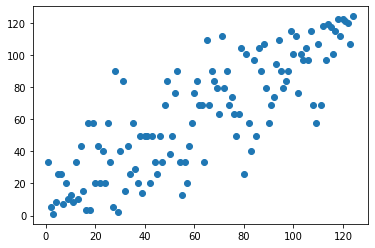

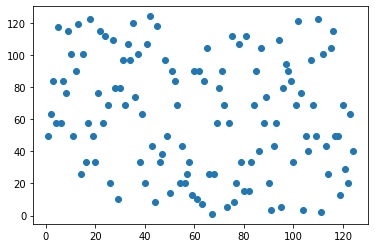

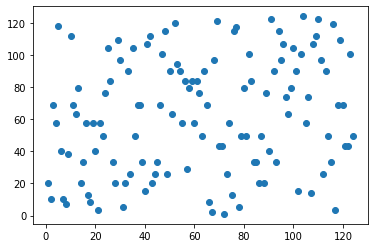

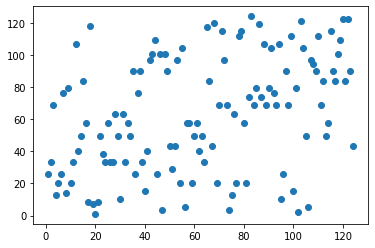

In [9]:
import matplotlib.pyplot as plt

plt.scatter(rank_confidences,rank_accs)
plt.show()

plt.scatter(rank_sensitivities,rank_accs)
plt.show()

plt.scatter(rank_robustnesses,rank_accs)
plt.show()

plt.scatter(rank_step_sims,rank_accs)
plt.show()

# Train a found model

In [10]:
trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
print(args)
args.save_dir = os.path.join(xargs.save_dir, "train")
print(args)

Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=1473, save_dir='./include_none_increase_lr-loop2-2_ep2', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)
Namespace(arch_nas_dataset=None, channel=16, config_path='./MY.config', data_path='../cifar.python', dataset='cifar10', max_nodes=4, num_cells=5, print_freq=200, rand_seed=1473, save_dir='./include_none_increase_lr-loop2-2_ep2/train', search_space_name='nas-bench-201', select_num=100, track_running_stats=0, workers=4)


In [11]:
print(config)

Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=200, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))


In [12]:
logger = prepare_logger(args)

cifar_train_config_path = "./MY.config"
###
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(cifar_train_config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, _, valid_loader = get_nas_search_loaders(train_data,
                                                        valid_data,
                                                        xargs.dataset,
                                                        "../configs/nas-benchmark/",
                                                        (config.batch_size, config.batch_size),
                                                        xargs.workers)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(
            xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

search_space = get_search_spaces("cell", xargs.search_space_name)
model_config = dict2config(
    {
        "name": "RANDOM",
        "C": xargs.channel,
        "N": xargs.num_cells,
        "max_nodes": xargs.max_nodes,
        "num_classes": class_num,
        "space": search_space,
        "affine": False,
        "track_running_stats": True, # true for eval
    },
    None,
)
search_model = get_cell_based_tiny_net(model_config)

### load
# trained_output = torch.load(os.path.join(xargs.save_dir, "output.pth"))
search_model.load_state_dict(trained_output['model'], strict=False)
best_archs = trained_output['best_archs']
i=0
for m in search_model.modules():
    if isinstance(m, SearchCell):
        m.arch_cache = best_archs[i]
        i += 1
for m in network.modules():
    if isinstance(m, SearchCell):
        print(m.arch_cache)
###

w_optimizer, w_scheduler, criterion = get_optim_scheduler(search_model.parameters(), config)

logger.log("w-optimizer : {:}".format(w_optimizer))
logger.log("w-scheduler : {:}".format(w_scheduler))
logger.log("criterion   : {:}".format(criterion))

network, criterion = torch.nn.DataParallel(search_model).cuda(), criterion.cuda()

last_info, model_base_path, model_best_path = (
    logger.path("info"),
    logger.path("model"),
    logger.path("best"),
)

start_epoch, valid_accuracies, genotypes = 0, {"best": -1}, {}

Main Function with logger : Logger(dir=include_none_increase_lr-loop2-2_ep2/train, use-tf=False, writer=None)
Arguments : -------------------------------
arch_nas_dataset : None
channel          : 16
config_path      : ./MY.config
data_path        : ../cifar.python
dataset          : cifar10
max_nodes        : 4
num_cells        : 5
print_freq       : 200
rand_seed        : 1473
save_dir         : ./include_none_increase_lr-loop2-2_ep2/train
search_space_name : nas-bench-201
select_num       : 100
track_running_stats : 0
workers          : 4
Python  Version  : 3.7.13 (default, Mar 29 2022, 02:18:16)  [GCC 7.5.0]
Pillow  Version  : 9.0.1
PyTorch Version  : 1.12.0
cuDNN   Version  : 8302
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None
Files already downloaded and verified
Files already downloaded and verified
./MY.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=50, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Soft

In [13]:
def search_func_one_arch(xloader, network, criterion, scheduler, w_optimizer, epoch_str, print_freq, logger):
    data_time, batch_time = AverageMeter(), AverageMeter()
    base_losses, base_top1, base_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.train()
    end = time.time()
    for step, (base_inputs, base_targets, arch_inputs, arch_targets) in enumerate(
        xloader
    ):
        scheduler.update(None, 1.0 * step / len(xloader))
        base_targets = base_targets.cuda(non_blocking=True)
        arch_targets = arch_targets.cuda(non_blocking=True)
        # measure data loading time
        data_time.update(time.time() - end)

        w_optimizer.zero_grad()
        _, logits = network(base_inputs)
        base_loss = criterion(logits, base_targets)
        base_loss.backward()
        nn.utils.clip_grad_norm_(network.parameters(), 5)
        w_optimizer.step()
        # record
        base_prec1, base_prec5 = obtain_accuracy(
            logits.data, base_targets.data, topk=(1, 5)
        )
        base_losses.update(base_loss.item(), base_inputs.size(0))
        base_top1.update(base_prec1.item(), base_inputs.size(0))
        base_top5.update(base_prec5.item(), base_inputs.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if step % print_freq == 0 or step + 1 == len(xloader):
            Sstr = (
                "*SEARCH* "
                + time_string()
                + " [{:}][{:03d}/{:03d}]".format(epoch_str, step, len(xloader))
            )
            Tstr = "Time {batch_time.val:.2f} ({batch_time.avg:.2f}) Data {data_time.val:.2f} ({data_time.avg:.2f})".format(
                batch_time=batch_time, data_time=data_time
            )
            Wstr = "Base [Loss {loss.val:.3f} ({loss.avg:.3f})  Prec@1 {top1.val:.2f} ({top1.avg:.2f}) Prec@5 {top5.val:.2f} ({top5.avg:.2f})]".format(
                loss=base_losses, top1=base_top1, top5=base_top5
            )
            logger.log(Sstr + " " + Tstr + " " + Wstr)
    return base_losses.avg, base_top1.avg, base_top5.avg

def valid_func_one_arch(xloader, network, criterion):
    data_time, batch_time = AverageMeter(), AverageMeter()
    arch_losses, arch_top1, arch_top5 = AverageMeter(), AverageMeter(), AverageMeter()
    network.eval()
    end = time.time()
    with torch.no_grad():
        for step, (arch_inputs, arch_targets) in enumerate(xloader):
            arch_targets = arch_targets.cuda(non_blocking=True)
            # measure data loading time
            data_time.update(time.time() - end)
            # prediction

#             network.module.random_genotype_per_cell(True)
            _, logits = network(arch_inputs)
            arch_loss = criterion(logits, arch_targets)
            # record
            arch_prec1, arch_prec5 = obtain_accuracy(
                logits.data, arch_targets.data, topk=(1, 5)
            )
            arch_losses.update(arch_loss.item(), arch_inputs.size(0))
            arch_top1.update(arch_prec1.item(), arch_inputs.size(0))
            arch_top5.update(arch_prec5.item(), arch_inputs.size(0))
            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
    return arch_losses.avg, arch_top1.avg, arch_top5.avg

In [14]:
start_time, search_time, epoch_time, total_epoch = (
    time.time(),
    AverageMeter(),
    AverageMeter(),
    config.epochs + config.warmup,
)
for epoch in range(0, total_epoch):
    w_scheduler.update(epoch, 0.0)
    need_time = "Time Left: {:}".format(
        convert_secs2time(epoch_time.val * (total_epoch - epoch), True)
    )
    epoch_str = "{:03d}-{:03d}".format(epoch, total_epoch)
    logger.log(
        "\n[Search the {:}-th epoch] {:}, LR={:}".format(
            epoch_str, need_time, min(w_scheduler.get_lr())
        )
    )

    # selected_arch = search_find_best(valid_loader, network, criterion, xargs.select_num)
    search_w_loss, search_w_top1, search_w_top5 = search_func_one_arch(
        search_loader,
        network,
        criterion,
        w_scheduler,
        w_optimizer,
        epoch_str,
        xargs.print_freq,
        logger,
    )
    search_time.update(time.time() - start_time)
    logger.log(
        "[{:}] searching : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%, time-cost={:.1f} s".format(
            epoch_str, search_w_loss, search_w_top1, search_w_top5, search_time.sum
        )
    )
    valid_a_loss, valid_a_top1, valid_a_top5 = valid_func_one_arch(
        valid_loader, network, criterion
    )
    logger.log(
        "[{:}] evaluate  : loss={:.2f}, accuracy@1={:.2f}%, accuracy@5={:.2f}%".format(
            epoch_str, valid_a_loss, valid_a_top1, valid_a_top5
        )
    )
    
    # check the best accuracy
    valid_accuracies[epoch] = valid_a_top1
    if valid_a_top1 > valid_accuracies["best"]:
        valid_accuracies["best"] = valid_a_top1
        find_best = True
    else:
        find_best = False

    # save checkpoint
    save_path = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(xargs),
            "search_model": search_model.state_dict(),
            "w_optimizer": w_optimizer.state_dict(),
            "w_scheduler": w_scheduler.state_dict(),
            "genotypes": genotypes,
            "valid_accuracies": valid_accuracies,
        },
        model_base_path,
        logger,
    )
    last_info = save_checkpoint(
        {
            "epoch": epoch + 1,
            "args": deepcopy(args),
            "last_checkpoint": save_path,
        },
        logger.path("info"),
        logger,
    )
    if find_best:
        logger.log(
            "<<<--->>> The {:}-th epoch : find the highest validation accuracy : {:.2f}%.".format(
                epoch_str, valid_a_top1
            )
        )
        copy_checkpoint(model_base_path, model_best_path, logger)
    if api is not None:
        logger.log("{:}".format(api.query_by_arch(genotypes[epoch], "200")))
    # measure elapsed time
    epoch_time.update(time.time() - start_time)
    start_time = time.time()

logger.close()


[Search the 000-050-th epoch] Time Left: [00:00:00], LR=0.025
*SEARCH* [2022-11-02 01:30:09] [000-050][000/391] Time 0.41 (0.41) Data 0.26 (0.26) Base [Loss 0.355 (0.355)  Prec@1 89.06 (89.06) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 01:30:30] [000-050][200/391] Time 0.09 (0.11) Data 0.00 (0.00) Base [Loss 0.244 (0.366)  Prec@1 89.06 (87.42) Prec@5 100.00 (99.64)]
*SEARCH* [2022-11-02 01:30:55] [000-050][390/391] Time 0.24 (0.12) Data 0.00 (0.00) Base [Loss 0.435 (0.373)  Prec@1 85.00 (87.30) Prec@5 100.00 (99.58)]
[000-050] searching : loss=0.37, accuracy@1=87.30%, accuracy@5=99.58%, time-cost=46.5 s
[000-050] evaluate  : loss=0.56, accuracy@1=81.24%, accuracy@5=99.15%
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth
<<<--->>> The 000-050-th epoch : find the highest validation accuracy : 81.24%.
copy the file from include_none_increase_lr-loop2-2_e

*SEARCH* [2022-11-02 01:39:15] [007-050][000/391] Time 0.45 (0.45) Data 0.30 (0.30) Base [Loss 0.266 (0.266)  Prec@1 90.62 (90.62) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 01:39:38] [007-050][200/391] Time 0.09 (0.12) Data 0.00 (0.00) Base [Loss 0.583 (0.355)  Prec@1 84.38 (87.83) Prec@5 98.44 (99.60)]
*SEARCH* [2022-11-02 01:39:58] [007-050][390/391] Time 0.08 (0.11) Data 0.00 (0.00) Base [Loss 0.570 (0.359)  Prec@1 80.00 (87.68) Prec@5 100.00 (99.59)]
[007-050] searching : loss=0.36, accuracy@1=87.68%, accuracy@5=99.59%, time-cost=371.1 s
[007-050] evaluate  : loss=0.49, accuracy@1=84.26%, accuracy@5=99.06%
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth
Find include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2

*SEARCH* [2022-11-02 01:48:36] [014-050][000/391] Time 0.42 (0.42) Data 0.26 (0.26) Base [Loss 0.219 (0.219)  Prec@1 89.06 (89.06) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 01:49:00] [014-050][200/391] Time 0.13 (0.12) Data 0.00 (0.00) Base [Loss 0.406 (0.301)  Prec@1 89.06 (89.88) Prec@5 98.44 (99.70)]
*SEARCH* [2022-11-02 01:49:20] [014-050][390/391] Time 0.18 (0.11) Data 0.00 (0.00) Base [Loss 0.249 (0.325)  Prec@1 92.50 (88.80) Prec@5 100.00 (99.70)]
[014-050] searching : loss=0.33, accuracy@1=88.80%, accuracy@5=99.70%, time-cost=718.4 s
[014-050] evaluate  : loss=0.50, accuracy@1=83.84%, accuracy@5=99.25%
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth
Find include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2

*SEARCH* [2022-11-02 01:57:56] [021-050][200/391] Time 0.13 (0.14) Data 0.00 (0.00) Base [Loss 0.337 (0.280)  Prec@1 85.94 (90.41) Prec@5 100.00 (99.80)]
*SEARCH* [2022-11-02 01:58:17] [021-050][390/391] Time 0.08 (0.13) Data 0.00 (0.00) Base [Loss 0.477 (0.285)  Prec@1 85.00 (90.20) Prec@5 100.00 (99.82)]
[021-050] searching : loss=0.28, accuracy@1=90.20%, accuracy@5=99.82%, time-cost=1057.5 s
[021-050] evaluate  : loss=0.45, accuracy@1=85.95%, accuracy@5=99.34%
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth
Find include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth
<<<--->>> The 021-050-th epoch : find the highest validation accuracy : 85.95%.
Find include_none_increase_lr-loop2-2_

*SEARCH* [2022-11-02 02:07:12] [028-050][000/391] Time 0.37 (0.37) Data 0.25 (0.25) Base [Loss 0.186 (0.186)  Prec@1 93.75 (93.75) Prec@5 100.00 (100.00)]
*SEARCH* [2022-11-02 02:07:39] [028-050][200/391] Time 0.14 (0.14) Data 0.00 (0.00) Base [Loss 0.254 (0.222)  Prec@1 93.75 (92.37) Prec@5 100.00 (99.91)]
*SEARCH* [2022-11-02 02:08:02] [028-050][390/391] Time 0.14 (0.13) Data 0.00 (0.00) Base [Loss 0.279 (0.225)  Prec@1 87.50 (92.20) Prec@5 100.00 (99.90)]
[028-050] searching : loss=0.23, accuracy@1=92.20%, accuracy@5=99.90%, time-cost=1424.3 s
[028-050] evaluate  : loss=0.47, accuracy@1=85.77%, accuracy@5=99.36%
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth
Find include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2

[034-050] evaluate  : loss=0.40, accuracy@1=87.99%, accuracy@5=99.50%
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth
Find include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth
<<<--->>> The 034-050-th epoch : find the highest validation accuracy : 87.99%.
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-best.pth exist, delete is at first before saving
copy the file from include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-best.pth

[Search the 035-050-th epoch] Time Left: [00:16:58], LR=0.005946576972490324
*SEARCH* [2022-11-02 02:16:30] [035-050][000/391] Time 0.50 (0.50) Da

*SEARCH* [2022-11-02 02:23:50] [040-050][390/391] Time 0.15 (0.13) Data 0.00 (0.00) Base [Loss 0.280 (0.104)  Prec@1 92.50 (96.46) Prec@5 100.00 (99.98)]
[040-050] searching : loss=0.10, accuracy@1=96.46%, accuracy@5=99.98%, time-cost=2001.8 s
[040-050] evaluate  : loss=0.38, accuracy@1=89.28%, accuracy@5=99.55%
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth
Find include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth
<<<--->>> The 040-050-th epoch : find the highest validation accuracy : 89.28%.
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-best.pth exist, delete is at first before saving
copy the file from include_none_increase_lr-loop2-2_ep2/train/checkpoint/s

[046-050] evaluate  : loss=0.38, accuracy@1=89.70%, accuracy@5=99.63%
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth
Find include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth exist, delete is at first before saving
save checkpoint into include_none_increase_lr-loop2-2_ep2/train/seed-1473-last-info.pth
<<<--->>> The 046-050-th epoch : find the highest validation accuracy : 89.70%.
Find include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-best.pth exist, delete is at first before saving
copy the file from include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-basic.pth into include_none_increase_lr-loop2-2_ep2/train/checkpoint/seed-1473-best.pth

[Search the 047-050-th epoch] Time Left: [00:04:30], LR=0.0012125529912557355
*SEARCH* [2022-11-02 02:32:22] [047-050][000/391] Time 0.49 (0.49) D

In [ ]:
best_archs